# NLP - CEIA - 2024

## Entrega 3 - Parte A


### Autor: Julio Donadello
### Email: juliodonadello@gmail.com

---

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


# Modelo de lenguaje con tokenización por palabras

## 1. Armado del dataset

In [64]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, GRU
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Datos
Como ejemplo se utilizará como corpus un dataset de descripciones de empresas en linkedin: https://www.kaggle.com/datasets/arshkon/linkedin-job-postings

In [2]:
ls

companies.csv.zip  sample_data/


In [3]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('companies.csv.zip', compression='zip')
df = df[['description']]

In [4]:
# función que toma solo las primeras 13 palabras de cada descripción
def first_13_words(text):
    if isinstance(text, str):  # Verifica si es una cadena de texto
        return ' '.join(text.split()[:13])
    return text

df['description'] = df['description'].apply(first_13_words)


In [5]:
df = df.iloc[0:1000]

In [6]:
df.head()

,description
0,"At IBM, we do more than work. We create. We cr..."
1,Every day millions of people feel the impact o...
2,Official LinkedIn of Hewlett Packard Enterpris...
3,We’re a cloud technology company that provides...
4,Accenture is a leading global professional ser...


In [7]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 1000


### Limpieza

In [8]:
#df['description'] = df['description'].str.split('\n').explode().reset_index(drop=True)
# Eliminar todo lo que está después del primer \n
#df['description'] = df['description'].str.split('\n').str[0]

In [9]:
df = df[df['description'].str.strip() != ''].reset_index(drop=True)

In [10]:
df = df[df['description'].apply(lambda x: isinstance(x, str))].dropna()

In [11]:
df['description'] = df['description'].apply(lambda x: x.replace("\'", "'") if isinstance(x, str) else x)

In [12]:
len(df)

1000

In [13]:
text = list(df['description'])
text[3]

'We’re a cloud technology company that provides organizations around the world with computing'

In [14]:
len(text[1])

81

### Elegir el tamaño del contexto

In [15]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding


In [16]:
# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

In [17]:
text[0]

'At IBM, we do more than work. We create. We create as technologists,'

In [18]:
segmented_sentences[0]

['at',
 'ibm',
 'we',
 'do',
 'more',
 'than',
 'work',
 'we',
 'create',
 'we',
 'create',
 'as',
 'technologists']

In [19]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

(array([  1.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,  32.,
        750., 161.,  43.,   0.,   9.,   1.,   0.,   0.,   1.]),
 array([ 4. ,  4.8,  5.6,  6.4,  7.2,  8. ,  8.8,  9.6, 10.4, 11.2, 12. ,
        12.8, 13.6, 14.4, 15.2, 16. , 16.8, 17.6, 18.4, 19.2, 20. ]),
 <BarContainer object of 20 artists>)

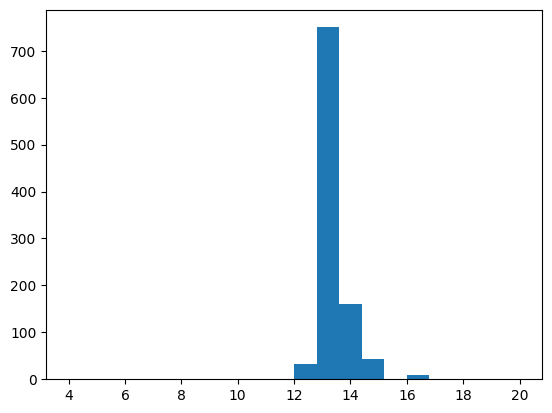

In [20]:
# podemos ver su distribución
plt.hist(length_sentences,bins=20)

In [21]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil, pero
# otros criterios también pueden ser válidos con la justificación adecuada.
# También puede ser una selección "a mano"

# el -1 es porque el último token será el target
max_context_size = int(np.percentile(length_sentences, 75)-1)

# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 12


###  Tokenizar

In [22]:
# instanciamos el tokenizador
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [23]:
tokenized_sentences[0]

[14, 1147, 8, 101, 19, 30, 63, 8, 54, 8, 54, 22, 688]

In [24]:
segmented_sentences[0]

['at',
 'ibm',
 'we',
 'do',
 'more',
 'than',
 'work',
 'we',
 'create',
 'we',
 'create',
 'as',
 'technologists']

### Organizando y estructurando el dataset

En este punto tenemos en la variable `tokenized_sentences` las descipciones de companies tokenizadas. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [25]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

*Vamos* a splitear las oraciones que tienen tamaño mayor al contexto máximo, para generarnos más secuencias de entrenamiento. Este paso puede obviarse si el tamaño de contexto máximo es muy grande.

Por ejemplo, si tenemos el texto *La bella y graciosa moza marchóse a lavar la ropa* y nuestro contexto es de 5 palabras, tendremos:

  - *La bella y graciosa moza*
  - *bella y graciosa moza marchóse*
  - *y graciosa moza marchóse a*
  - *graciosa moza marchóse a lavar*
  - *moza marchóse a lavar la*
  - *marchóse a lavar la ropa*

In [26]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)


In [27]:
len(tok_sent)

1026

### Data Augmentation

In [28]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))


In [29]:
len(tok_sent_augm[3])

12

In [30]:
max_context_size

12

In [31]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [32]:
train_seqs.shape

(12270, 13)

In [33]:
len(tokenized_sentences_val)

200

In [34]:
len(tokenized_sentences_val[5])

13

In [35]:
train_seqs[2]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,   55,   56,
       1192,  712], dtype=int32)

In [36]:
train_seqs[10002]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   13,
         10, 2087], dtype=int32)

In [37]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,1:]

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

In [38]:
X.shape

(12270, 12)

In [39]:
y.shape

(12270, 12)

In [40]:
# Palabras del vocabulario
tok.index_word

{1: 'the',
 2: 'is',
 3: 'a',
 4: 'and',
 5: 'of',
 6: 'in',
 7: 'to',
 8: 'we',
 9: 'global',
 10: 'company',
 11: 'leading',
 12: 'for',
 13: 'our',
 14: 'at',
 15: 'that',
 16: 'with',
 17: 'leader',
 18: 'solutions',
 19: 'more',
 20: 'technology',
 21: 'services',
 22: 'as',
 23: 'one',
 24: 'are',
 25: 'world',
 26: 'people',
 27: 'an',
 28: 'university',
 29: 'health',
 30: 'than',
 31: 'has',
 32: 'on',
 33: 'nyse',
 34: 'world’s',
 35: 'largest',
 36: 'financial',
 37: 'inc',
 38: 'business',
 39: 'founded',
 40: 'provider',
 41: 'by',
 42: 'research',
 43: 'years',
 44: 'group',
 45: 'you',
 46: 'been',
 47: 'mission',
 48: 'industry',
 49: 'corporation',
 50: 'digital',
 51: 'we’re',
 52: 'companies',
 53: 'firm',
 54: 'create',
 55: 'u',
 56: 's',
 57: 'energy',
 58: 'it',
 59: 'care',
 60: 'international',
 61: 'medical',
 62: 'information',
 63: 'work',
 64: 'nasdaq',
 65: '000',
 66: 'help',
 67: 'purpose',
 68: 'customers',
 69: 'management',
 70: 'businesses',
 71: 'th

In [41]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

3129

In [42]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'the': 1, 'is': 2, 'a': 3, 'and': 4, 'of': 5, 'in': 6, 'to': 7, 'we': 8, 'global': 9, 'company': 10, 'leading': 11, 'for': 12, 'our': 13, 'at': 14, 'that': 15, 'with': 16, 'leader': 17, 'solutions': 18, 'more': 19, 'technology': 20, 'services': 21, 'as': 22, 'one': 23, 'are': 24, 'world': 25, 'people': 26, 'an': 27, 'university': 28, 'health': 29, 'than': 30, 'has': 31, 'on': 32, 'nyse': 33, 'world’s': 34, 'largest': 35, 'financial': 36, 'inc': 37, 'business': 38, 'founded': 39, 'provider': 40, 'by': 41, 'research': 42, 'years': 43, 'group': 44, 'you': 45, 'been': 46, 'mission': 47, 'industry': 48, 'corporation': 49, 'digital': 50, 'we’re': 51, 'companies': 52, 'firm': 53, 'create': 54, 'u': 55, 's': 56, 'energy': 57, 'it': 58, 'care': 59, 'international': 60, 'medical': 61, 'information': 62, 'work': 63, 'nasdaq': 64, '000': 65, 'help': 66, 'purpose': 67, 'customers': 68, 'management': 69, 'businesses': 70, 'their': 71, 'helps': 72, 'focused': 73, 'life': 74, 'make': 75, 'its': 76, '

In [43]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'we': 201, 'as': 72, 'more': 76, 'ibm': 1, 'do': 15, 'work': 22, 'technologists': 2, 'create': 24, 'at': 117, 'than': 58, 'devices': 3, 'every': 16, 'people': 64, 'day': 10, 'intelligent': 4, 'impact': 4, 'millions': 9, 'feel': 3, 'advanced': 10, 'our': 117, 'of': 329, 'the': 460, 'official': 8, 'hewlett': 1, 'global': 181, 'passion': 4, 'enterprise': 8, 'sharing': 1, 'linkedin': 12, 'to': 235, 'company': 137, 'cloud': 9, 'packard': 2, 'edge': 6, 'with': 111, 'world': 63, 'computing': 2, 'around': 10, 'provides': 12, 'that': 114, 'we’re': 25, 'a': 438, 'technology': 77, 'organizations': 16, 'world’s': 49, 'professional': 11, 'is': 511, 'accenture': 1, 'helps': 20, 'services': 77, 'leading': 135, 'ours': 1, "what's": 1, 'empower': 5, 'person': 1, 'and': 418, 'mission': 27, 'has': 55, 'become': 2, 'drives': 4, 'help': 21, 'wherever': 1, 'deloitte': 1, 'leaders': 8, 'clients': 15, 'progress': 8, 'firms': 6, 'berlin': 1, 'on': 55, 'munich': 1, 'ag': 1, 'focused'


## Definir el modelo

In [44]:
model = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))

model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(100, return_sequences=True))
#model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
model.add(Dense(vocab_size+1, activation='softmax'))


# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, None, 50)            │         156,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, None, 100)           │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, None, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, None, 100)           │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, None, 3130)          │         316,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 613,430 (2.34 MB)

 Trainable params: 613,430 (2.34 MB)

 Non-trainable params: 0 (0.00 B)

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [45]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad y la paciencia para detener el entrenamiento.
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model.h5")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


## Entrenamiento

In [46]:
X[1]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 55, 56], dtype=int32)

Nota: El callback para el calculo de la perplejidad carga todas las predicciones del conjunto de validación en memoria para cada época

In [47]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=10, callbacks=[PplCallback(tokenized_sentences_val,history_ppl, patience=4)], batch_size=64)

Epoch 1/10
191/192 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.8567


 mean perplexity: 999.5016711708905 

Saved new model!
192/192 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 5.8460
Epoch 2/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.0239
 mean perplexity: 1177.157702378931 

192/192 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 4.0239
Epoch 3/10
191/192 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9780
 mean perplexity: 1046.0915130468297 

192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.9776
Epoch 4/10
185/192 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.8894
 mean perplexity: 1073.718646638741 

192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.8884
Epoch 5/10
191/192 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.7866
 mean perplexity: 1089.1040361806508 

Stopping training...
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.7867


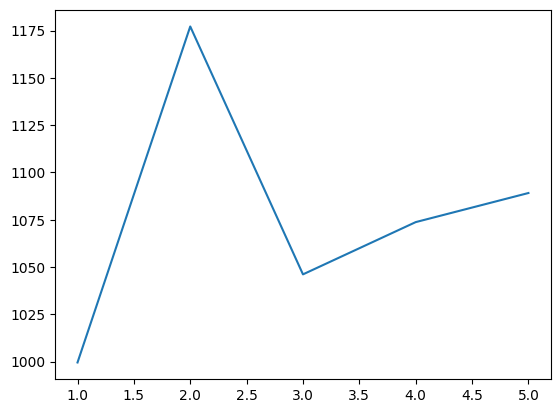

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
print()
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [49]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model.h5')


## Predicción de próxima palabra

In [50]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 14.4 MB/s eta 0:00:00


In [51]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://2000a8d4279e23569e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://2000a8d4279e23569e.gradio.live


## Generación de secuencias

In [52]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	  # generate a fixed number of words
    for _ in range(n_words):
		  # Tokenizamos
      encoded = tokenizer.texts_to_sequences([output_text])[0]

		  # Si tienen distinto largo
      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		  # Predicción softmax
      y_hat = np.argmax(model.predict(encoded)[0,-1,:])

      # Vamos concatenando las predicciones
      out_word = ''

      # Debemos buscar en el vocabulario la palabra
      # que corresopnde al indice (y_hat) predicho por le modelo
      for word, index in tokenizer.word_index.items():
        if index == y_hat:
          out_word = word
          break

		  # Agrego las palabras a la frase predicha
      output_text += ' ' + out_word

    return output_text

In [53]:
input_text='At amazon we think'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


'At amazon we think is is is is is is is is is is'

##  Beam search y muestreo aleatorio

In [54]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [55]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [56]:
# predicción con beam search.
# Se pueden camiar los modos entre 'det' (determinista) y
# 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas_Amazon = beam_search(model,num_beams=3,num_words=20,input="At amazon we think",temp=1,mode='sto')
salidas_IBM = beam_search(model,num_beams=3,num_words=20,input="At ibm we think",temp=1,mode='sto')
salidas_google = beam_search(model,num_beams=3,num_words=20,input="At google we think",temp=1,mode='sto')

In [57]:
# tenemos `num_beams` salidas ordenadas de mayor a menor likelihood
salidas_Amazon.shape

(3, 32)

In [58]:
# veamos las salidas
print(decode(salidas_Amazon[0]))
print(decode(salidas_IBM[0]))
print(decode(salidas_google[0]))

['at amazon we think and the in follow candidate is nasdaq the global agency more and']
['at ibm we think the construction more data customer group award is help the is the we that the the at and herbalife the']
['at we think services a global schools the the world’s price powers an the 000 crain people read the nyse to a of']


# Conclusión

1. La primera iteración de este trabajo práctico se realizó sobre un dataset de tweets sin resultados exitosos en términos de la métrica de perplejidad, ni en el comportamiento del modelo para predecir palabras. En este caso, se trabajó con un tamaño de contexto de 20 palabras, lo cual pudo haber limitado la capacidad del modelo para captar adecuadamente las dependencias entre palabras, sobre todo considerando la naturaleza corta y el lenguaje informal de los tweets.

2. En la segunda iteración, se utilizó un dataset con mayor cantidad de datos y un tamaño de contexto ampliado a 77 palabras, con la intención de mejorar la captura de contexto y reducir la perplejidad. Sin embargo, la métrica de perplejidad seguía siendo alta, superando incluso el tamaño del vocabulario, lo que indica que el modelo no lograba generalizar adecuadamente. Este resultado puede deberse a varios factores, entre ellos un vocabulario muy amplio, la falta de suficiente entrenamiento o la necesidad de ajustar otros hiperparámetros como el tamaño del embedding o la arquitectura del modelo.
Se probó aplicar técnicas de regularización como el dropout, para evitar el sobreajuste. Y también se probo agregando nuevas capas densas, pero esto aumentaba el consumo en memoria.


3. A partir de los resultados obtenidos, es evidente que el modelo necesita una mayor optimización. La elección del dataset y de los contextos utilizados puede no ser adecuada. Una posible solución podría ser reducir el tamaño del vocabulario. Por otro lado, se podría explorar arquitecturas de modelos más sofisticadas, como redes neuronales recurrentes, que suelen manejar mejor secuencias largas.También podría ayudar el uso de capas preentrenadas.

4. Por ultimo se sobreescribió el notebook acortando los documentos del dataset a 13 palabras cada uno. Luego se reentreno y los resultados obtenidos son mejores.
  - La metrica de perplejidad es menor al tamaño del vocabulario.
  - Se logró disminuir en gran medida el valor de la métrica (la misma divergia con el dataset de context_size=77)
  - El comportamiento del modelo a la hora de predecir es malo pero logra escapar de predecir siempre el mismo token por default mediante el muestreo estocástico.

---

## Prueba con GRU

In [60]:
model.pop()
model.pop()
model.pop()

<Dropout name=dropout, built=True>

In [61]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, None, 50)            │         156,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, None, 100)           │          60,400 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 216,902 (847.28 KB)

 Trainable params: 216,900 (847.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [62]:
model.pop()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, None, 50)            │         156,500 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,502 (611.34 KB)

 Trainable params: 156,500 (611.33 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [65]:
model.add(GRU(100, return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(100, return_sequences=True))
model.add(Dense(vocab_size+1, activation='softmax'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, None, 50)            │         156,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, None, 100)           │          45,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, None, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, None, 100)           │          60,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, None, 3130)          │         316,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 578,832 (2.21 MB)

 Trainable params: 578,830 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [66]:
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

### Reentrenamiento

In [67]:
history_ppl = []
hist = model.fit(X, y, epochs=10, callbacks=[PplCallback(tokenized_sentences_val,history_ppl, patience=4)], batch_size=64)

Epoch 1/10
185/192 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.2544


 mean perplexity: 1073.6215591111184 

Saved new model!
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 5.2218
Epoch 2/10
189/192 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9007
 mean perplexity: 1100.137314402379 

192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.9001
Epoch 3/10
185/192 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.7751
 mean perplexity: 1112.055099624159 

192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 3.7723
Epoch 4/10
190/192 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.5875
 mean perplexity: 1154.9732415653664 

192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 3.5868
Epoch 5/10
185/192 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.4402
 mean perplexity: 1190.624492784935 

Stopping training...
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 3.4387


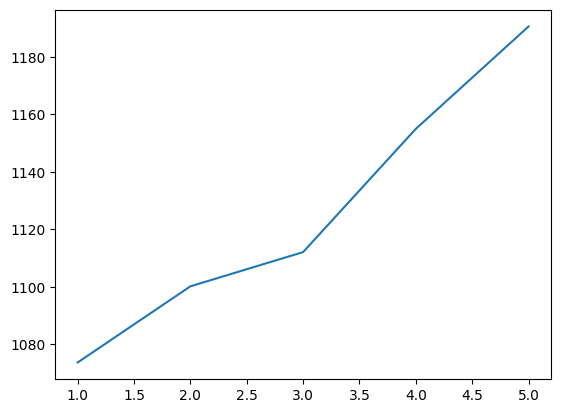

In [68]:
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

## Beam Search

In [69]:
input_text = "At amazon we think"
generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


'At amazon we think and than than than years years and the in the'

### Estocástico

In [72]:
salidas = beam_search(model, num_beams=3, num_words=10, input="At amazon we think", temp=1, mode='sto')

In [73]:
print(decode(salidas[0]))

['at amazon we think it 300 solutions is a leading fortune do thinkers acxiom®']


### Determinista

In [74]:
salidas = beam_search(model, num_beams=3, num_words=10, input="At amazon we think", temp=1, mode='det')

In [75]:
print(decode(salidas[0]))

['at amazon we think is a leading the of the in the in the']


### Variando la temperatura

In [82]:
salidas = beam_search(model, num_beams=3, num_words=10, input="At amazon we think", temp=2, mode='sto')

In [83]:
print(decode(salidas[0]))

['at amazon we think bidmc in reliable health at “to cancer chicago serving people']


In [84]:
salidas = beam_search(model, num_beams=3, num_words=10, input="At amazon we think", temp=7, mode='sto')

In [85]:
print(decode(salidas[0]))

['at amazon we think williams driving reshaping assurance 1848 board tracing providers jesuit commitment']
